**Goal**

Can we accurately predict whether an individual survives the Titanic or not using datasets with known outcomes?

# Import and clean Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet

The training dataset includes information regarding, passenger ID, survived, class, name, sex, age, siblings/spouses on board, Parents with children on board, ticket #, fare paid, cabin #, and where they embarked.  

I believe that Class, sex, age, siblings/spouse, cabin and where they embarked will affect the survival rates for these reasons:
- class: better access to information and lifeboats, 
- sex: more females survived than males (bias), 
- age: as the younger you are the harder you will struggle to survive and also be placed on a lifeboat, 
- siblings/spouse: those that travel together would look after each other, and 
- cabin: perhaps the location affects access to lifeboats
- embarkation: possible socio-economic reasons or length of trip depends what cabin is purchased?

In [2]:
train_data = pd.read_csv('data/train.csv')#,na_values=[''])
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# EDA

Train a model that is as accurate as possible to predict the survival rates of passengers

In [3]:
train_data.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


In [4]:
train_data.groupby('SibSp').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked
SibSp,,,,,,,,,,,
0,608,608,608,608,608,471,608,608,608,126,606
1,209,209,209,209,209,183,209,209,209,69,209
2,28,28,28,28,28,25,28,28,28,6,28
3,16,16,16,16,16,12,16,16,16,3,16
4,18,18,18,18,18,18,18,18,18,0,18
5,5,5,5,5,5,5,5,5,5,0,5
8,7,7,7,7,7,0,7,7,7,0,7


Text(0.5, 0, 'Survived (0 = Dead,1 = Survived)')

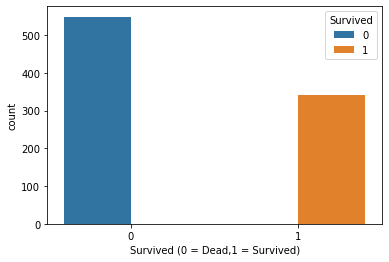

In [5]:
#this is full data
sns.countplot(data=train_data, x ='Survived', hue = 'Survived')
plt.xlabel('Survived (0 = Dead,1 = Survived)' )

Text(0.5, 0, 'Survived (0 = Dead,1 = Survived)')

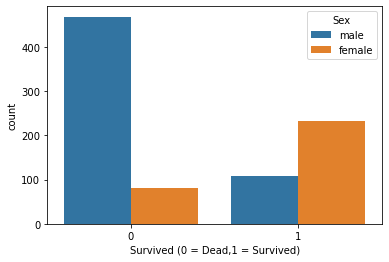

In [6]:
sns.countplot(x="Survived",
              hue="Sex",
              data=train_data)
plt.xlabel('Survived (0 = Dead,1 = Survived)' )

Text(0.5, 0, 'Survived (0 = Dead,1 = Survived)')

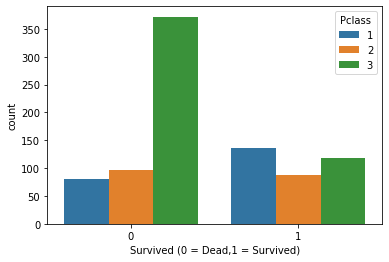

In [7]:
sns.countplot(x="Survived",
              hue="Pclass",
              data=train_data)
plt.xlabel('Survived (0 = Dead,1 = Survived)' )

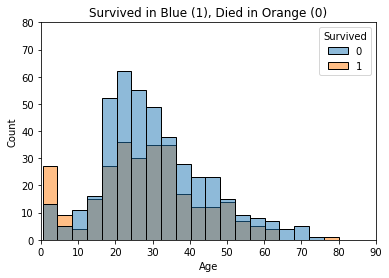

In [8]:
sns.histplot(data = train_data, x ='Age', bins=20, hue = 'Survived')
plt.xlim(0,90)
plt.ylim(0, 80)
plt.title('Survived in Blue (1), Died in Orange (0)').get_figure().savefig('titanic_graph.png')



# Data Engineering

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
train_data['Fare']=train_data['Fare'].astype(int)

In [11]:
#pd.factorize(train_data['Sex'])
train_data['Sex_factorized'] = pd.factorize(train_data['Sex'])[0]
#train_data[['Sex', 'Sex_factorized']]
#male = 0, female = 1

In [12]:
train_data['Cabin'] = train_data['Cabin'].astype(object)

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             714 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    int64  
 10  Cabin           204 non-null    object 
 11  Embarked        889 non-null    object 
 12  Sex_factorized  891 non-null    int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 90.6+ KB


In [14]:
train_data['Cabin_initials'] = train_data['Cabin'].str[:1]
train_data['Cabin_initials'].fillna('U', inplace = True)
#train_data

In [15]:
train_data['Cabin_factorized'] = pd.factorize(train_data['Cabin_initials'])[0]
pd.factorize(train_data['Cabin_initials'])
train_data[['Cabin_initials', 'Cabin_factorized']]

,Cabin_initials,Cabin_factorized
0,U,0
1,C,1
2,U,0
3,C,1
4,U,0
...,...,...
886,U,0
887,B,6
888,U,0
889,C,1


In [16]:
train_data['Embarked_factorized'] = pd.factorize(train_data['Embarked'])[0]
pd.factorize(train_data['Embarked'])
train_data[['Embarked', 'Embarked_factorized']]

,Embarked,Embarked_factorized
0,S,0
1,C,1
2,S,0
3,S,0
4,S,0
...,...,...
886,S,0
887,S,0
888,S,0
889,C,1


In [17]:
#train_data.isna().sum()

In [18]:
train_data['Age_filled'] = train_data['Age'].fillna(train_data.groupby('Sex')['Pclass'].transform('mean'))

In [19]:
train_data['Age_filled']=train_data['Age_filled'].astype(int)

In [20]:
train_data.isna().sum()

PassengerId              0
Survived                 0
Pclass                   0
Name                     0
Sex                      0
Age                    177
SibSp                    0
Parch                    0
Ticket                   0
Fare                     0
Cabin                  687
Embarked                 2
Sex_factorized           0
Cabin_initials           0
Cabin_factorized         0
Embarked_factorized      0
Age_filled               0
dtype: int64

# Train-test split, define y and X

In [21]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_factorized,Cabin_initials,Cabin_factorized,Embarked_factorized,Age_filled
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7,NaN,S,0,U,0,0,22
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71,C85,C,1,C,1,1,38


In [22]:
#drop the column "Survived" from file as we are creating a ML to predict
#y is true data (Y_true) the survivors from the original file, we will try and predict Y_new
X = train_data[['Pclass','Fare', 'SibSp', 'Sex_factorized', 'Age_filled','Cabin_factorized', 'Embarked_factorized']]
y = train_data["Survived"]

In [23]:
X.shape, y.shape

((891, 7), (891,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668, 7), (223, 7), (668,), (223,))

In [26]:
#X_train.info()

In [27]:
#X_test.info()

In [28]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
#    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [29]:
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler()
)

In [30]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_factorized',
       'Cabin_initials', 'Cabin_factorized', 'Embarked_factorized',
       'Age_filled'],
      dtype='object')

In [31]:
#num_pipe.fit_transform(df[['Age']])

In [32]:
feature_transform = ColumnTransformer([
    ('num_preprocessing', num_pipe, ['Age'])
])

In [33]:
feature_transform

ColumnTransformer(transformers=[('num_preprocessing',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Age'])])

In [34]:
#X_train_trans = feature_transform.fit_transform(X_train)

In [35]:
#X_train_trans

# Modeling

## Logistic Regression

In [36]:
X_trainLR, X_testLR, y_trainLR, y_testLR = train_test_split(X,y, test_size = 0.25)

In [37]:
# check the shape
X_trainLR.shape, y_trainLR.shape, X_testLR.shape, y_testLR.shape

((668, 7), (668,), (223, 7), (223,))

In [38]:
# build and fit the model
m_lgr = LogisticRegression(max_iter=1000) 

m_lgr.fit(X_trainLR,y_trainLR)

LogisticRegression(max_iter=1000)

In [39]:
# Get the estimated probabilities
estim_prob = m_lgr.predict_proba(X_trainLR)
estim_prob

array([[0.88083151, 0.11916849],
       [0.90000173, 0.09999827],
       [0.49745426, 0.50254574],
       ...,
       [0.12462178, 0.87537822],
       [0.06142723, 0.93857277],
       [0.8516963 , 0.1483037 ]])

In [40]:
#pd.DataFrame(data=estim_prob,columns=m_lgr.classes_)

In [41]:
# Calculate the prediction
y_predLR = m_lgr.predict(X_trainLR)
#y_predLR

In [42]:
# Calculate the accuracy
accuracy = m_lgr.score(X_trainLR,y_trainLR)
print(f'the Logistic regression has achieved an accuracy score: {round(accuracy,3)}')

the Logistic regression has achieved an accuracy score: 0.798


### Cross Validation on Logistic Regression

In [43]:
cross_accuracy_logLR = cross_val_score(m_lgr,  #estimator: the model that you want to evalueate
                                     X_trainLR, # the training data
                                     y_trainLR,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_LR=np.round_(cross_accuracy_logLR, 3)
CAL_LR

array([0.716, 0.821, 0.776, 0.805, 0.789])

## RandomForest with Scikit

In [44]:
rfc = RandomForestClassifier(n_estimators=70, max_depth=4)    #Hyperparam: n_estimators(number of trees)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=70)

In [45]:
y_pred = rfc.predict(X)

In [46]:
round(rfc.score(X_train, y_train),3)

0.847

In [47]:
round(rfc.score(X_test, y_test),3)

0.816

In [48]:
importance = rfc.feature_importances_
importance

array([0.12445036, 0.14827944, 0.0330275 , 0.48952706, 0.06158818,
       0.11315028, 0.02997717])

In [49]:
# summarize feature importance
for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,   v))

Feature: 0, Score: 0.12445
Feature: 1, Score: 0.14828
Feature: 2, Score: 0.03303
Feature: 3, Score: 0.48953
Feature: 4, Score: 0.06159
Feature: 5, Score: 0.11315
Feature: 6, Score: 0.02998


([<matplotlib.axis.XTick at 0x147a8cac0>,
 [Text(0.12445036484724693, 0, 'Feature 0'),
  Text(0.148279441606549, 0, 'Feature 1'),
  Text(0.033027495962906085, 0, 'Feature 2'),
  Text(0.48952705805547986, 0, 'Feature 3'),
  Text(0.06158818221123843, 0, 'Feature 4'),
  Text(0.11315028386543888, 0, 'Feature 5'),
  Text(0.02997717345114085, 0, 'Feature 6')])

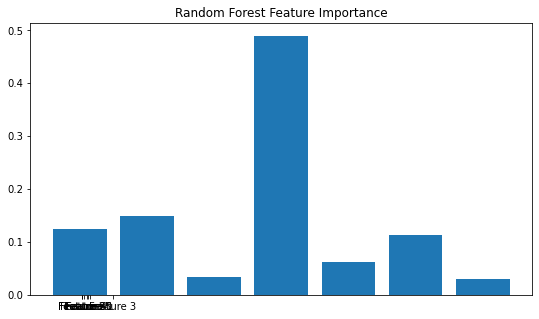

In [50]:
fig = plt.figure(figsize=(9,5))

plt.bar([x for x in range(len(importance))], importance)
plt.title('Random Forest Feature Importance')
plt.xticks(importance, ('Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6'))

In [51]:
print(f"""precision = {round(precision_score(y,y_pred),2)} \n 
recall = {round(recall_score(y,y_pred),2)}\n
f1 = {round(f1_score(y,y_pred),2)}""")

precision = 0.87 
 
recall = 0.68

f1 = 0.77


### Cross Validation RFC

In [52]:
cross_accuracy_logRFC = cross_val_score(rfc,  #estimator: the model that you want to evalueate
                                     X_train, # the training data
                                     y_train
                                        ,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_RFC = np.round_(cross_accuracy_logRFC, 3)
CAL_RFC

array([0.799, 0.843, 0.791, 0.782, 0.872])

### Confusion Matrix, ROC etc

In [53]:
conf = confusion_matrix(y, y_pred)
conf

array([[515,  34],
       [109, 233]])

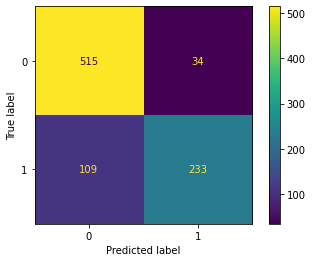

In [54]:
cm = confusion_matrix(y, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc.classes_)
disp.plot()
plt.show()

In [55]:
def plot_heatmap(confusion):
    
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion,
                xticklabels = np.unique(y),
                yticklabels = np.unique(y),
                cmap = 'BuPu',
                annot=True,
                fmt='g'
                )

    # fmt is used to switch off scientific notation
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize = 14).get_figure().savefig('titanic_confusionmatrix.png')

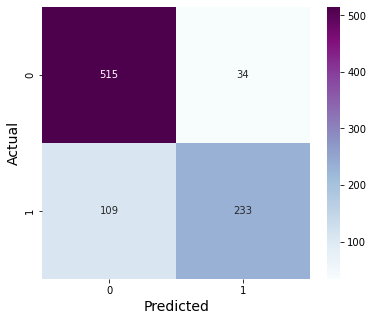

In [56]:
plot_heatmap(conf)

In [57]:
probs = rfc.predict_proba(X) 
probs

array([[0.84341562, 0.15658438],
       [0.10598978, 0.89401022],
       [0.5475551 , 0.4524449 ],
       ...,
       [0.5588659 , 0.4411341 ],
       [0.59356409, 0.40643591],
       [0.85342131, 0.14657869]])

/Users/karenbolon/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


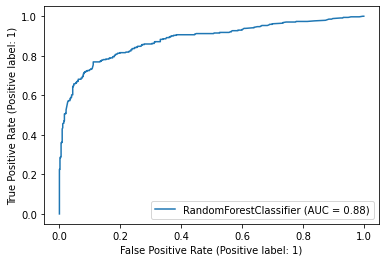

In [58]:
plot_roc_curve(rfc, X, y)   
#plt.plot(0.05, 0.97,'ro')

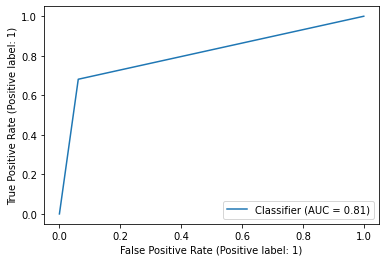

In [59]:
RocCurveDisplay.from_predictions(y, y_pred)
plt.show()

In [60]:
fpr, tpr, threshold = roc_curve(y, probs[:,1]);

In [61]:
tpr - fpr

array([0.        , 0.00292398, 0.00877193, 0.01461988, 0.02046784,
       0.02631579, 0.02923977, 0.03508772, 0.05555556, 0.06140351,
       0.19590643, 0.20175439, 0.2251462 , 0.22332471, 0.24379254,
       0.24964049, 0.28180424, 0.27998274, 0.2858307 , 0.2840092 ,
       0.30447704, 0.31032499, 0.35418464, 0.35236315, 0.35528712,
       0.35346563, 0.37100949, 0.38562937, 0.3944013 , 0.41194516,
       0.42071709, 0.42474355, 0.44521139, 0.44631387, 0.44449238,
       0.45618828, 0.45436679, 0.45729077, 0.46313872, 0.4660627 ,
       0.47191065, 0.48945451, 0.48581152, 0.4887355 , 0.48691401,
       0.49276196, 0.50153389, 0.50445787, 0.53992906, 0.54103154,
       0.54395552, 0.54213402, 0.53849104, 0.54433899, 0.54726297,
       0.54544147, 0.55128943, 0.54946793, 0.55239191, 0.55057042,
       0.55641837, 0.56226632, 0.55862333, 0.59955901, 0.59773751,
       0.60358547, 0.60176397, 0.6105359 , 0.60689292, 0.6079954 ,
       0.6061739 , 0.60909788, 0.60727639, 0.61312434, 0.60948

In [62]:
max_index = np.argmax(tpr - fpr)
max_index

105

In [63]:
print(threshold[max_index],
      fpr[max_index],
      tpr[max_index])

0.44397681911899495 0.1111111111111111 0.7690058479532164


In [64]:
auc_score = auc(fpr, tpr)
print("Area under the curve = ",auc_score)

Area under the curve =  0.882822569477732


In [65]:
rfc.score(X_train, y_train)

0.8473053892215568

In [66]:
rfc.score(X_test, y_test)

0.8161434977578476

In [67]:
cross_accuracy_log = cross_val_score(rfc,  #estimator: the model that you want to evalueate
                                     X_train, # the training data
                                     y_train,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy') # evaluation metric



In [68]:
cross_accuracy_log

array([0.7761194 , 0.85074627, 0.78358209, 0.80451128, 0.86466165])

In [69]:
cross_accuracy_log.mean()

0.8159241387049715

## Support Vector Machine

In [70]:
X_trainSV, X_testSV, y_trainSV, y_testSV = train_test_split(X,y, test_size = 0.25)

In [71]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_trainSV, y_trainSV)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [72]:
print(f'train_score={clf.score(X_trainSV, y_trainSV)},test_score={clf.score(X_testSV, y_testSV)}')

train_score=0.8233532934131736,test_score=0.8430493273542601


### Cross Validation on SVM

In [73]:
cross_accuracy_logSV = cross_val_score(clf,  #estimator: the model that you want to evalueate
                                     X_trainSV, # the training data
                                     y_trainSV,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_SV=np.round_(cross_accuracy_logSV, 3)

In [74]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest Classifier', 'Support Vector Machine'],
    
     'Cross_Accuracy_Log': [CAL_LR, CAL_RFC, CAL_SV]
})



In [75]:
results

,Model,Cross_Accuracy_Log
0,Logistic Regression,"[0.716, 0.821, 0.776, 0.805, 0.789]"
1,Random Forest Classifier,"[0.799, 0.843, 0.791, 0.782, 0.872]"
2,Support Vector Machine,"[0.791, 0.806, 0.784, 0.797, 0.782]"
